In [1]:
! mkdir PLOTS-lhlhc

mkdir: cannot create directory ‘PLOTS-lhlhc’: File exists


In [2]:
import json
import glob
import re

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

In [3]:
pre = pd.read_csv("~/storage/data/physicists/pyhep2020-preworkshop-survey.csv")
post = pd.read_csv("~/storage/data/physicists/pyhep2020-postworkshop-survey.csv")

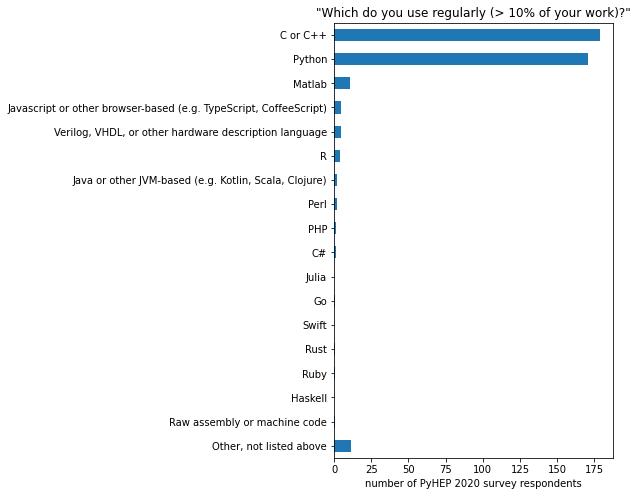

In [4]:
languages = [
    "C or C++",
    "Python",
    "Matlab",
    "Javascript or other browser-based (e.g. TypeScript, CoffeeScript)",
    "Verilog, VHDL, or other hardware description language",
    "R",
    "Java or other JVM-based (e.g. Kotlin, Scala, Clojure)",
    "Perl",
    "PHP",
    "C#",
    "Julia",
    "Go",
    "Swift",
    "Rust",
    "Ruby",
    "Haskell",
    "Raw assembly or machine code",
    "Other, not listed above",
]
def explode(responses):
    responses = [response.strip() for response in responses.split(";")]
    return [1.0 if language in responses else 0.0 for language in languages]
exploded = pre[["Computing and programming: Which of the following languages do you use regularly (i.e. more than 10% of your work)?"]].fillna("").applymap(explode)
indicator = pd.DataFrame(exploded.iloc[:, 0].tolist(), columns=languages)
ax = indicator.div(indicator.sum(axis=1), axis=0).sum(axis=0).iloc[::-1].plot.barh(figsize=(5, 8))
plt.title("\"Which do you use regularly (> 10% of your work)?\"")
plt.xlabel("number of PyHEP 2020 survey respondents")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-languages.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-languages.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-languages.png")

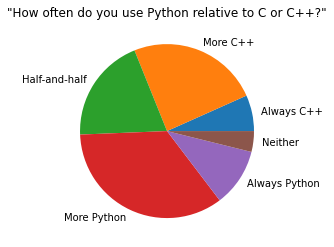

In [5]:
ax = pre['Computing and programming: About how often do you use Python relative to C or C++?'].value_counts(ascending=True)[["Always C++", "More C++", "Half-and-half", "More Python", "Always Python", "Neither"]].plot.pie()
plt.title("\"How often do you use Python relative to C or C++?\"")
plt.ylabel("")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-cpp-vs-python.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-cpp-vs-python.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-cpp-vs-python.png")

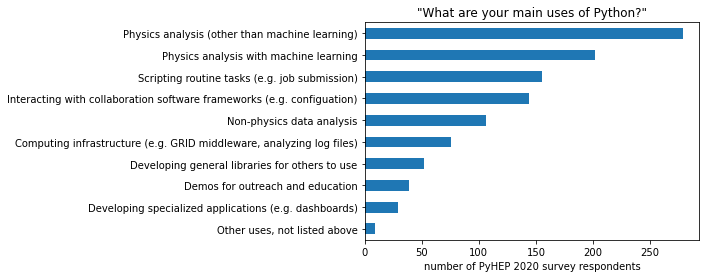

In [6]:
ax = pd.DataFrame(pre['Computing and programming: How would you characterize your main use(s) of Python?'].fillna("No response").str.split("; ").tolist()).stack().value_counts(ascending=True)[[
 'Physics analysis (other than machine learning)',
 'Physics analysis with machine learning',
 'Scripting routine tasks (e.g. job submission)',
 'Interacting with collaboration software frameworks (e.g. configuation)',
 'Non-physics data analysis',
 'Computing infrastructure (e.g. GRID middleware, analyzing log files)',
 'Developing general libraries for others to use',
 'Demos for outreach and education',
 'Developing specialized applications (e.g. dashboards)',
 'Other uses, not listed above',
][::-1]].plot.barh()
plt.title("\"What are your main uses of Python?\"")
plt.xlabel("number of PyHEP 2020 survey respondents")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-reasons-for-python.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-reasons-for-python.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-reasons-for-python.png")

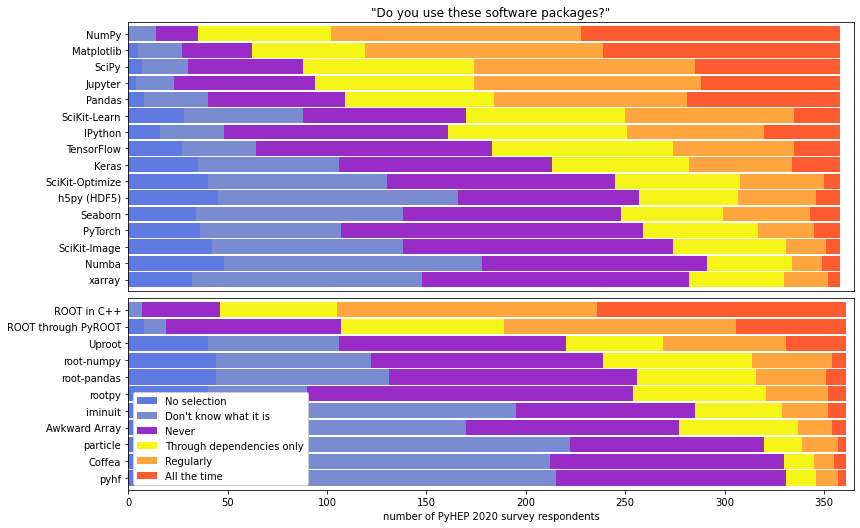

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(13, 8.6), gridspec_kw={"height_ratios": [1.4, 1]})

cols = {x: x.split(":")[1].strip() for x in pre.columns if x.startswith("Python ecosystem:") and "?" not in x}
order = ((pre[list(cols)] == "Don't know what it is") | (pre[list(cols)] == "Never")).sum(axis=0).sort_values(ascending=False).index[-16:].tolist()
pkgs = pre[order].rename(columns=cols).apply(pd.Series.value_counts).T[[
    "Don't know what it is", "Never", "Through dependencies only", "Regularly", "All the time"
]].fillna(0)
pkgs.insert(0, "No selection", pkgs.sum(axis=1).max() - pkgs.sum(axis=1))
pkgs.plot.barh(stacked=True, width=0.9, color=["#5e79e0", "#798bd1", "#992cc7", "#f5f518", "#ffa640", "#ff5a30"], ax=ax1)
ax1.get_legend().remove()
ax1.set_title("\"Do you use these software packages?\"")
ax1.set_xticks([])
ax1.set_xlim(0, 365)

cols = {x: x.split(":")[1].strip() for x in pre.columns if x.startswith("Particle physics ecosystem:") and "?" not in x}
order = ((pre[list(cols)] == "Don't know what it is") | (pre[list(cols)] == "Never")).sum(axis=0).sort_values(ascending=False).index[-16:][[0, 1, 2, 5, 6, 7, 8, 9, 11, 12, 13]].tolist()
pkgs = pre[order].rename(columns=cols).apply(pd.Series.value_counts).T[[
    "Don't know what it is", "Never", "Through dependencies only", "Regularly", "All the time"
]].fillna(0)
pkgs.insert(0, "No selection", pkgs.sum(axis=1).max() - pkgs.sum(axis=1))
pkgs.plot.barh(stacked=True, width=0.9, color=["#5e79e0", "#798bd1", "#992cc7", "#f5f518", "#ffa640", "#ff5a30"], ax=ax2)
ax2.legend(loc="lower left", framealpha=1)
ax2.set_xlabel("number of PyHEP 2020 survey respondents")
ax2.set_xlim(0, 365)

plt.subplots_adjust(hspace=0.03)

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-familiarity-with-packages.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-familiarity-with-packages.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-familiarity-with-packages.png")

In [8]:
pip = pd.read_csv("~/storage/data/physicists/pip-counts-2021-04-28.csv", parse_dates=["date"])
pip.set_index(["project", "date"], inplace=True)

packages = pip.index.levels[0].tolist()
by_package = {}
for package in packages:
    tmp = pip.loc[package]
    by_package[package] = tmp.resample("10D", origin=pd.to_datetime("2020-07-24"))["count"].sum()
all_packages = pd.DataFrame(by_package, index=by_package["iminuit"].index).fillna(0)

all_packages["uproot"] += all_packages["uproot3"]
all_packages["uproot"] += all_packages["uproot4"]
all_packages["awkward"] += all_packages["awkward0"]
all_packages["awkward"] += all_packages["awkward1"]

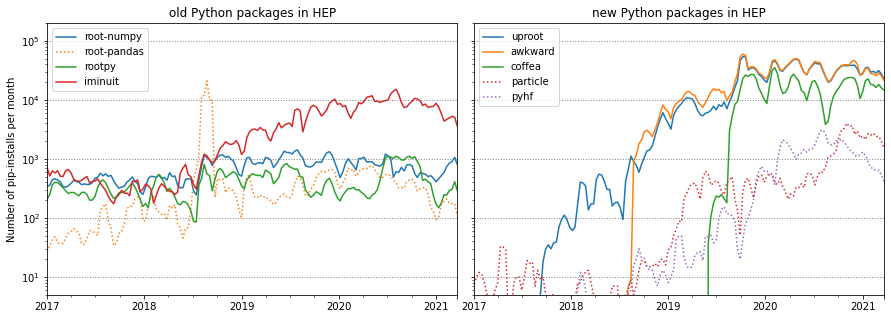

In [9]:
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(15, 5))

all_packages[[
    "uproot", "awkward", "coffea", "particle", "pyhf"
]].rolling(3).sum().plot(logy=True, style=["-", "-", "-", ":", ":"], ax=ax1)
ax1.set_ylim(5, 200000)
ax1.set_xlim(pd.to_datetime("2017-01-01"), all_packages.index[-1])
ax1.legend(loc="upper left")
ax1.grid(color="gray", linestyle=":", linewidth=1, axis="y")
ax2.set_title("old Python packages in HEP")
ax1.set_xlabel("")
ax2.set_ylabel("Number of pip-installs per month")

all_packages[[
    "root-numpy", "root-pandas", "rootpy", "iminuit"
]].rolling(3).sum().plot(logy=True, style=["-", ":", "-", "-"], ax=ax2)
ax2.set_ylim(5, 200000)
ax2.set_xlim(pd.to_datetime("2017-01-01"), all_packages.index[-1])
ax2.legend(loc="upper left")
ax2.grid(color="gray", linestyle=":", linewidth=1, axis="y")
ax1.set_title("new Python packages in HEP")
ax2.set_xlabel("")
ax1.set_ylabel("")
ax1.set_yticklabels([])

plt.subplots_adjust(wspace=0.04)

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-pip-download-rates.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-pip-download-rates.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-pip-download-rates.png")

In [10]:
userrepos_lists = {
    "repo_id": [],
    "owner_login": [],
    "owner_id": [],
    "repo_name": [],
    "created_at": [],
    "pushed_at": [],
    "updated_at": [],
    "fork": [],
    "language": [],
    "size": [],
    "description": [],
    "homepage": [],
    "license": [],
    "forks_count": [],
    "open_issues_count": [],
    "stargazers_count": [],
    "watchers_count": [],
}
for filename in glob.glob("/home/jpivarski/storage/data/physicists/forks-of-cmssw-2021-02-24/user-repos/*.json"):
    for repo in json.load(open(filename)):
        userrepos_lists["repo_id"].append(repo["id"])
        userrepos_lists["owner_login"].append(repo["owner"]["login"])
        userrepos_lists["owner_id"].append(repo["owner"]["id"])
        userrepos_lists["repo_name"].append(repo["name"])
        userrepos_lists["created_at"].append(pd.to_datetime(repo["created_at"]))
        userrepos_lists["pushed_at"].append(pd.to_datetime(repo["pushed_at"]))
        userrepos_lists["updated_at"].append(pd.to_datetime(repo["updated_at"]))
        userrepos_lists["fork"].append(repo["fork"])
        userrepos_lists["language"].append(repo["language"])
        userrepos_lists["size"].append(repo["size"])
        userrepos_lists["description"].append(repo["description"])
        userrepos_lists["homepage"].append(repo["homepage"])
        userrepos_lists["license"].append(None if repo["license"] is None else repo["license"]["name"])
        userrepos_lists["forks_count"].append(repo["forks_count"])
        userrepos_lists["open_issues_count"].append(repo["open_issues_count"])
        userrepos_lists["stargazers_count"].append(repo["stargazers_count"])
        userrepos_lists["watchers_count"].append(repo["watchers_count"])

In [11]:
userrepos = pd.DataFrame(userrepos_lists)

In [12]:
users_with_cmssw = userrepos[(userrepos["repo_name"] == "cmssw") & (userrepos["fork"])]["owner_login"]
userrepos_cut = userrepos[userrepos["owner_login"].isin(users_with_cmssw)]
userrepos_cut = userrepos_cut[~userrepos_cut["fork"]]

userrepos_cut["Python"] = userrepos_cut["language"] == "Python"
userrepos_cut["Jupyter"] = userrepos_cut["language"] == "Jupyter Notebook"
userrepos_cut["C and C++"] = (userrepos_cut["language"] == "C") | (userrepos_cut["language"] == "C++")

In [13]:
def smooth(series, colors, styles, ax):
    for s, c, st in zip(series, colors, styles):
        s[(pd.to_datetime("2013-01-01") < s.index.values) & (s.index.values < pd.to_datetime("2021-02-01"))].rolling(
            2, center=True, win_type="gaussian"
        ).mean(std=1.5).plot(color=c, linestyle=st, ax=ax)

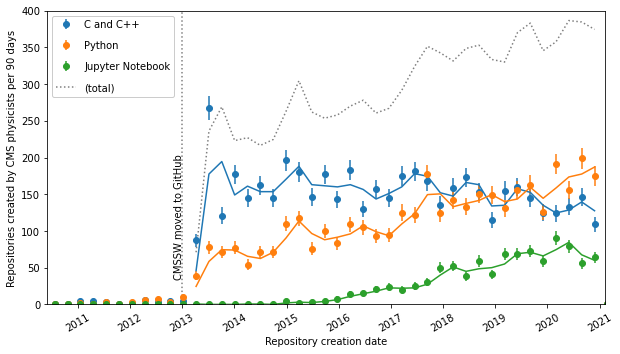

In [14]:
physicists = userrepos_cut.copy()
physicists.index = physicists["created_at"]
bylanguage = physicists[["C and C++", "Python", "Jupyter"]].resample("90D", origin=userrepos_cut["created_at"].max()).sum()
ax = bylanguage.plot(yerr=np.sqrt(bylanguage), marker="o", ls="none", rot=0, figsize=(10, 6))
smooth([bylanguage["C and C++"], bylanguage["Python"], bylanguage["Jupyter"], bylanguage["C and C++"] + bylanguage["Python"] + bylanguage["Jupyter"]],
       ["tab:blue", "tab:orange", "tab:green", "tab:gray"], ["-"] * 3 + [":"], ax)
ax.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.5*240, "CMSSW moved to GitHub", rotation=90, va="center")
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax.set_xticklabels(years, ha="center")
ax.set_xlabel("Repository creation date")
ax.set_ylabel("Repositories created by CMS physicists per 90 days")
ax.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax.set_ylim(0, 400)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:] + handles[3:4], [
    "C and C++", "Python", "Jupyter Notebook", "(total)"
], loc="upper left", labelspacing=1.1, framealpha=1)

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-languages.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-languages.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-languages.png")

In [15]:
def get_search_vstime(directory, wildcard="*", parent="forks-of-cmssw-2021-02-24/searches"):
    search_lists = {
        "repo_id": [],
        "owner_login": [],
        "owner_id": [],
        "repo_name": [],
        "path": [],
        "fork": [],
    }

    for filename in glob.glob("/home/jpivarski/storage/data/physicists/{}/{}/{}.json".format(parent, directory, wildcard)):
        jsondata = json.load(open(filename))
        if jsondata.get("message") != "Validation Failed":
            for match in jsondata["items"]:
                search_lists["repo_id"].append(match["repository"]["id"])
                search_lists["owner_login"].append(match["repository"]["owner"]["login"])
                search_lists["owner_id"].append(match["repository"]["owner"]["id"])
                search_lists["repo_name"].append(match["repository"]["name"])
                search_lists["path"].append(match["path"])
                search_lists["fork"].append(match["repository"]["fork"])

    search = pd.DataFrame(search_lists)
    search.set_index(["owner_login", "repo_name"], inplace=True, drop=False)

    search_vstime = pd.merge(search, userrepos.set_index(["owner_login", "repo_name"]), left_index=True, right_index=True)
    search_vstime = search_vstime[~search_vstime["fork_y"]]
    search_vstime.set_index(["owner_login", "repo_name", "created_at"], inplace=True)
    search_vstime = search_vstime.groupby(level=2).max()["repo_id_x"] != 0
    search_vstime = search_vstime.resample("90D", origin=userrepos_cut["created_at"].max()).sum()
    return search_vstime

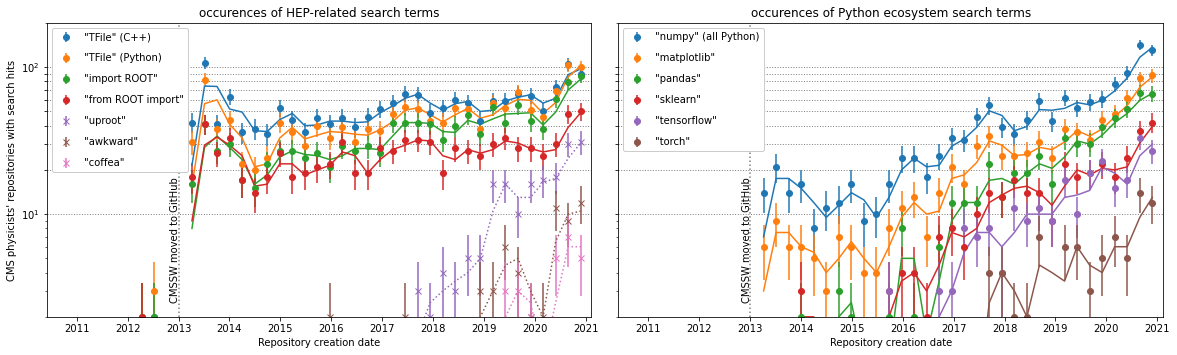

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

search_cpp_tfile = get_search_vstime("cpp-tfile")
search_python_tfile = get_search_vstime("python-tfile")
search_python_import_root = get_search_vstime("python-import-root")
search_python_from_root_import = get_search_vstime("python-from-root-import")
search_uproot_vstime = get_search_vstime("python-uproot")
search_awkward_vstime = get_search_vstime("python-awkward")
search_coffea_vstime = get_search_vstime("python-coffea")

search_cpp_tfile.plot(yerr=np.sqrt(search_cpp_tfile), marker="o", ls="none", rot=0, logy=True, ax=ax1)
search_python_tfile.plot(yerr=np.sqrt(search_python_tfile), marker="o", ls="none", rot=0, logy=True, ax=ax1)
search_python_import_root.plot(yerr=np.sqrt(search_python_import_root), marker="o", ls="none", rot=0, logy=True, ax=ax1)
search_python_from_root_import.plot(yerr=np.sqrt(search_python_from_root_import), marker="o", ls="none", rot=0, logy=True, ax=ax1)
search_uproot_vstime.plot(yerr=np.sqrt(search_uproot_vstime), marker="x", ls="none", rot=0, logy=True, ax=ax1)
search_awkward_vstime.plot(yerr=np.sqrt(search_awkward_vstime), marker="x", ls="none", rot=0, logy=True, ax=ax1)
search_coffea_vstime.plot(yerr=np.sqrt(search_coffea_vstime), marker="x", ls="none", rot=0, logy=True, ax=ax1)
smooth([search_cpp_tfile, search_python_tfile, search_python_import_root, search_python_from_root_import, search_uproot_vstime, search_awkward_vstime, search_coffea_vstime],
       plt.rcParams["axes.prop_cycle"].by_key()["color"], ["-", "-", "-", "-", ":", ":", ":"], ax1)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax1.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax1.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax1.set_xticklabels(years, ha="center", rotation=0)
ax1.set_xlabel("Repository creation date")
ax1.set_ylabel("CMS physicists' repositories with search hits")
ax1.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax1.set_ylim(2, 200)
ax1.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], [
    "\"TFile\" (C++)", "\"TFile\" (Python)", "\"import ROOT\"", "\"from ROOT import\"", "\"uproot\"", "\"awkward\"", "\"coffea\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax1.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax1.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.053*125, "CMSSW moved to GitHub", rotation=90, va="center")
ax1.set_title("occurences of HEP-related search terms")

search_numpy = get_search_vstime("python-numpy")
search_matplotlib = get_search_vstime("python-matplotlib")
search_pandas = get_search_vstime("python-pandas")
search_sklearn = get_search_vstime("python-sklearn")
search_tensorflow = get_search_vstime("python-tensorflow")
search_torch = get_search_vstime("python-torch")

search_numpy.plot(yerr=np.sqrt(search_numpy), marker="o", ls="none", rot=0, logy=True, ax=ax2)
search_matplotlib.plot(yerr=np.sqrt(search_matplotlib), marker="o", ls="none", rot=0, logy=True, ax=ax2)
search_pandas.plot(yerr=np.sqrt(search_pandas), marker="o", ls="none", rot=0, logy=True, ax=ax2)
search_sklearn.plot(yerr=np.sqrt(search_sklearn), marker="o", ls="none", rot=0, logy=True, ax=ax2)
search_tensorflow.plot(yerr=np.sqrt(search_tensorflow), marker="o", ls="none", rot=0, logy=True, ax=ax2)
search_torch.plot(yerr=np.sqrt(search_torch), marker="o", ls="none", rot=0, logy=True, ax=ax2)
smooth([search_numpy, search_matplotlib, search_pandas, search_sklearn, search_tensorflow, search_torch],
       plt.rcParams["axes.prop_cycle"].by_key()["color"] * 2, ["-"] * 6, ax2)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax2.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax2.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax2.set_xticklabels(years, ha="center", rotation=0)
ax2.set_xlabel("Repository creation date")
ax2.set_yticklabels([])
ax2.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax2.set_ylim(2, 200)
ax2.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2[6:], [
    "\"numpy\" (all Python)", "\"matplotlib\"", "\"pandas\"", "\"sklearn\"", "\"tensorflow\"", "\"torch\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax2.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax2.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.053*125, "CMSSW moved to GitHub", rotation=90, va="center")
ax2.set_title("occurences of Python ecosystem search terms")

plt.subplots_adjust(wspace=0.05)

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-log.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-log.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-log.png")

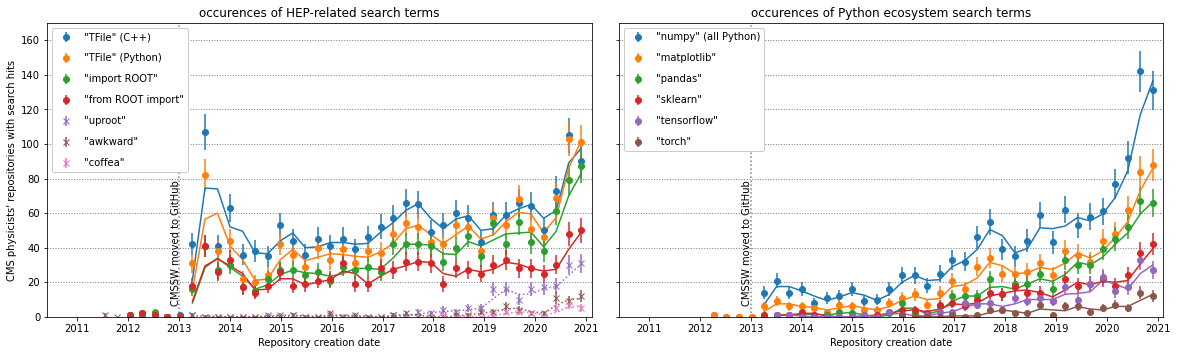

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

search_cpp_tfile.plot(yerr=np.sqrt(search_cpp_tfile), marker="o", ls="none", rot=0, logy=False, ax=ax1)
search_python_tfile.plot(yerr=np.sqrt(search_python_tfile), marker="o", ls="none", rot=0, logy=False, ax=ax1)
search_python_import_root.plot(yerr=np.sqrt(search_python_import_root), marker="o", ls="none", rot=0, logy=False, ax=ax1)
search_python_from_root_import.plot(yerr=np.sqrt(search_python_from_root_import), marker="o", ls="none", rot=0, logy=False, ax=ax1)
search_uproot_vstime.plot(yerr=np.sqrt(search_uproot_vstime), marker="x", ls="none", rot=0, logy=False, ax=ax1)
search_awkward_vstime.plot(yerr=np.sqrt(search_awkward_vstime), marker="x", ls="none", rot=0, logy=False, ax=ax1)
search_coffea_vstime.plot(yerr=np.sqrt(search_coffea_vstime), marker="x", ls="none", rot=0, logy=False, ax=ax1)
smooth([search_cpp_tfile, search_python_tfile, search_python_import_root, search_python_from_root_import, search_uproot_vstime, search_awkward_vstime, search_coffea_vstime],
       plt.rcParams["axes.prop_cycle"].by_key()["color"], ["-", "-", "-", "-", ":", ":", ":"], ax1)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax1.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax1.set_xticklabels(years, ha="center", rotation=0)
ax1.set_xlabel("Repository creation date")
ax1.set_ylabel("CMS physicists' repositories with search hits")
ax1.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax1.set_ylim(0, 170)
ax1.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], [
    "\"TFile\" (C++)", "\"TFile\" (Python)", "\"import ROOT\"", "\"from ROOT import\"", "\"uproot\"", "\"awkward\"", "\"coffea\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax1.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax1.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.34*125, "CMSSW moved to GitHub", rotation=90, va="center")
ax1.set_title("occurences of HEP-related search terms")

search_numpy.plot(yerr=np.sqrt(search_numpy), marker="o", ls="none", rot=0, logy=False, ax=ax2)
search_matplotlib.plot(yerr=np.sqrt(search_matplotlib), marker="o", ls="none", rot=0, logy=False, ax=ax2)
search_pandas.plot(yerr=np.sqrt(search_pandas), marker="o", ls="none", rot=0, logy=False, ax=ax2)
search_sklearn.plot(yerr=np.sqrt(search_sklearn), marker="o", ls="none", rot=0, logy=False, ax=ax2)
search_tensorflow.plot(yerr=np.sqrt(search_tensorflow), marker="o", ls="none", rot=0, logy=False, ax=ax2)
search_torch.plot(yerr=np.sqrt(search_torch), marker="o", ls="none", rot=0, logy=False, ax=ax2)
smooth([search_numpy, search_matplotlib, search_pandas, search_sklearn, search_tensorflow, search_torch],
       plt.rcParams["axes.prop_cycle"].by_key()["color"] * 2, ["-"] * 6, ax2)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax2.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax2.set_xticklabels(years, ha="center", rotation=0)
ax2.set_xlabel("Repository creation date")
ax2.set_yticklabels([])
ax2.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax2.set_ylim(0, 170)
ax2.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2[6:], [
    "\"numpy\" (all Python)", "\"matplotlib\"", "\"pandas\"", "\"sklearn\"", "\"tensorflow\"", "\"torch\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax2.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax2.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.34*125, "CMSSW moved to GitHub", rotation=90, va="center")
ax2.set_title("occurences of Python ecosystem search terms")

plt.subplots_adjust(wspace=0.05)

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-lin.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-lin.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-searches-lin.png")

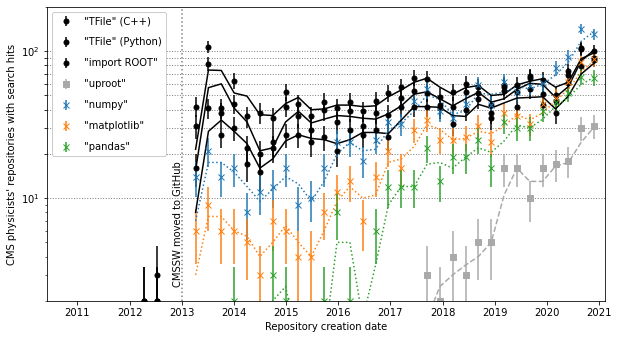

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

search_cpp_tfile.plot(yerr=np.sqrt(search_cpp_tfile), marker="o", markersize=5, ls="none", rot=0, logy=True, color="black", ax=ax1)
search_python_tfile.plot(yerr=np.sqrt(search_python_tfile), marker="o", markersize=5, ls="none", rot=0, logy=True, color="black", ax=ax1)
search_python_import_root.plot(yerr=np.sqrt(search_python_import_root), marker="o", markersize=5, ls="none", rot=0, logy=True, color="black", ax=ax1)
search_uproot_vstime.plot(yerr=np.sqrt(search_uproot_vstime), marker="s", ls="none", rot=0, logy=True, color="darkgray", ax=ax1)
search_numpy.plot(yerr=np.sqrt(search_numpy), marker="x", ls="none", rot=0, logy=True, color="tab:blue", ax=ax1)
search_matplotlib.plot(yerr=np.sqrt(search_matplotlib), marker="x", ls="none", rot=0, logy=True, color="tab:orange", ax=ax1)
search_pandas.plot(yerr=np.sqrt(search_pandas), marker="x", ls="none", rot=0, logy=True, color="tab:green", ax=ax1)

smooth([search_cpp_tfile, search_python_tfile, search_python_import_root, search_uproot_vstime, search_numpy, search_matplotlib, search_pandas],
       ["black", "black", "black", "darkgray"] + plt.rcParams["axes.prop_cycle"].by_key()["color"], ["-", "-", "-", "dashed", ":", ":", ":", ":"], ax1)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax1.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax1.set_xticklabels(years, ha="center", rotation=0)
ax1.set_xlabel("Repository creation date")
ax1.set_ylabel("CMS physicists' repositories with search hits")
ax1.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax1.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax1.set_ylim(2, 200)
ax1.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], [
    "\"TFile\" (C++)", "\"TFile\" (Python)", "\"import ROOT\"", "\"uproot\"", "\"numpy\"", "\"matplotlib\"", "\"pandas\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax1.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax1.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.053*125, "CMSSW moved to GitHub", rotation=90, va="center")

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-log.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-log.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-log.png")

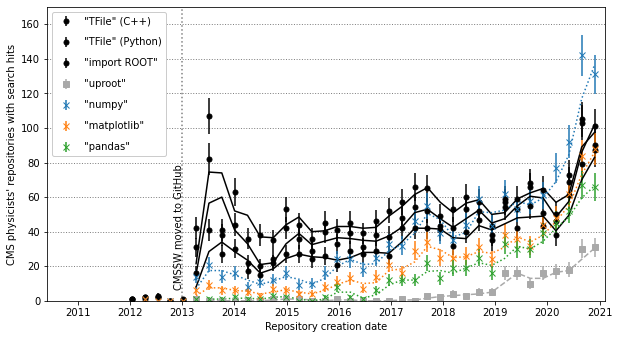

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

search_cpp_tfile.plot(yerr=np.sqrt(search_cpp_tfile), marker="o", markersize=5, ls="none", rot=0, logy=False, color="black", ax=ax1)
search_python_tfile.plot(yerr=np.sqrt(search_python_tfile), marker="o", markersize=5, ls="none", rot=0, logy=False, color="black", ax=ax1)
search_python_import_root.plot(yerr=np.sqrt(search_python_import_root), marker="o", markersize=5, ls="none", rot=0, logy=False, color="black", ax=ax1)
search_uproot_vstime.plot(yerr=np.sqrt(search_uproot_vstime), marker="s", ls="none", rot=0, logy=False, color="darkgray", ax=ax1)
search_numpy.plot(yerr=np.sqrt(search_numpy), marker="x", ls="none", rot=0, logy=False, color="tab:blue", ax=ax1)
search_matplotlib.plot(yerr=np.sqrt(search_matplotlib), marker="x", ls="none", rot=0, logy=False, color="tab:orange", ax=ax1)
search_pandas.plot(yerr=np.sqrt(search_pandas), marker="x", ls="none", rot=0, logy=False, color="tab:green", ax=ax1)

smooth([search_cpp_tfile, search_python_tfile, search_python_import_root, search_uproot_vstime, search_numpy, search_matplotlib, search_pandas],
       ["black", "black", "black", "darkgray"] + plt.rcParams["axes.prop_cycle"].by_key()["color"], ["-", "-", "-", "dashed", ":", ":", ":", ":"], ax1)
years = ("2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021")
ax1.set_xticks([pd.to_datetime(x + "-01-01") for x in years])
ax1.set_xticklabels(years, ha="center", rotation=0)
ax1.set_xlabel("Repository creation date")
ax1.set_ylabel("CMS physicists' repositories with search hits")
ax1.set_xlim(pd.to_datetime("2010-06-01"), pd.to_datetime("2021-02-10"))
ax1.set_ylim(0, 170)
ax1.grid(color="gray", linestyle=":", linewidth=1, axis="y")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[7:], [
    "\"TFile\" (C++)", "\"TFile\" (Python)", "\"import ROOT\"", "\"uproot\"", "\"numpy\"", "\"matplotlib\"", "\"pandas\"",
], loc="upper left", labelspacing=1.1, framealpha=1)
ax1.axvline(pd.to_datetime("2013-01-01"), c="gray", ls=":")
ax1.text(pd.to_datetime("2013-01-01") - pd.to_timedelta("60 days"), 0.34*125, "CMSSW moved to GitHub", rotation=90, va="center")

ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-lin.svg")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-lin.pdf")
ax.get_figure().savefig("PLOTS-lhlhc/lhlhc-github-overlay-lin.png")